## Imports (Run this)

In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import csv
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
from utils import *
from autoencoder import Autoencoder

## Configuration and Constants (Run this)

In [3]:
# Defining the constants and configurations used throughout the notebook.
iterations = 2101000 # 101000 exists but seems to be corrupted. 
on_remote = False
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')
k = 1 # 150
spinup = 1001
spacing = 10 # Change this to something larger if you want to use less data.
p_train = 0.8
mean_data = 0.003394413273781538
std_data = 9.174626350402832

## Data Loading (Run these 2)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = QGSamplesDataset(data_path, 'train', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
val_dataset = QGSamplesDataset(data_path, 'val', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)
test_dataset = QGSamplesDataset(data_path, 'test', p_train, k, spinup, spacing, iterations, mean_data, std_data, device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

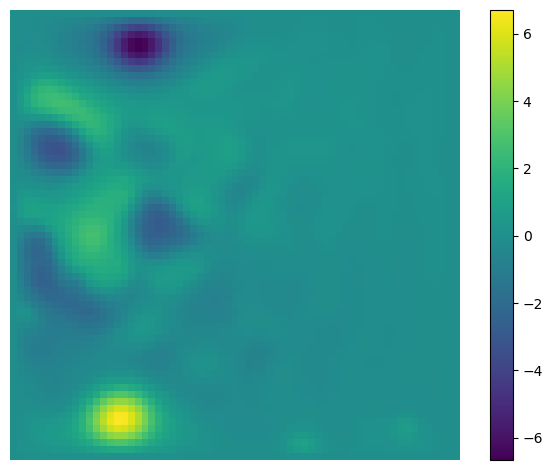

In [5]:
# Retrieve a batch of data from the dataloader
batch = next(iter(val_loader))

# Select a sample from the batch
sample = batch[0][0]  # Assuming the input data is at index 0

# Convert the sample to a numpy array
data = sample.cpu().detach().numpy()

# Plot the data using imshow
plt.imshow(data.reshape((65, 65)))
plt.colorbar()  # Add a colorbar for reference
plt.axis('off')  # Remove axis
plt.tight_layout()
plt.show()


### Only run once when creating new files

In [ ]:
# Only run once
#if False:

    # Defining the constants and configurations used throughout the notebook.

import numpy as np
from pathlib import Path

on_remote = True
data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}.npy')

max_number = 20  # The number of additional files to load
iterations = 101000
spinup = 1001

# Calculate total_rows as you have specified
total_rows = iterations + 1 + max_number*(iterations + 1 - spinup)
total_columns = 4225

# Specify the dtype
dtype = 'float32'

# Create a memmap file
memmap_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{total_rows-1}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{total_rows-1}.npy')

X_subs = np.memmap(memmap_path, dtype=dtype, mode='w+', shape=(total_rows, total_columns))

# Load initial data directly into the memmap array
#SUBS_data_filename = Path('SUBS_data_filename_here.npy')  # Specify the path
X_subs_initial = np.load(data_path).astype(dtype)
X_subs[:X_subs_initial.shape[0], :] = X_subs_initial

current_index = X_subs_initial.shape[0]

# Load additional data
for number in range(1, max_number + 1):
    print(f'Loading additional data {number}')
    SUBS_add_data_filename = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}_{number}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{iterations}_{number}.npy')

    X_subs_add = np.load(SUBS_add_data_filename).astype(dtype)[1:, :]  # Skip the first row

    next_index = current_index + X_subs_add.shape[0]
    X_subs[current_index:next_index, :] = X_subs_add
    current_index = next_index

# Flush changes to disk
X_subs.flush()

print(f'Final shape: {X_subs.shape}')

In [8]:
# Calculate mean and var
# Initialize variables for mean and standard deviation
mean_data = 0.0
std_data = 0.0
count = 0

# Iterate over the batches in train_loader
for batch in train_loader:
    # Get the input data from the batch
    inputs, _ = batch
    count += inputs.size(0)

    # Calculate the sum of the input data
    mean_data += torch.sum(inputs)
    std_data += torch.sum(inputs ** 2)

# Calculate the mean and standard deviation
count = count * 4225
mean_data /= count
std_data = torch.sqrt(std_data / count - mean_data ** 2)

# Print the mean and standard deviation
print("Mean:", mean_data.item())
print("Standard Deviation:", std_data.item())


Mean: -0.00229572388343513
Standard Deviation: 0.9848536252975464


## PCA

Much of what is here is old and not updated to work with DataLoader

### Run PCA

In [6]:
# Load the data and preprocess it for analysis.

# Data preprocessing function
def generate_data(p_train, k, spinup, spacing, iterations, X_subs):
    """
    Generate training, validation, and test data from the provided dataset.
    
    Parameters:
    p_train (float): Percentage of data to be used for training.
    k (int): Time steps for prediction.
    spinup (int): Initial data to be ignored.
    spacing (int): Data spacing interval.
    iterations (int): Total number of iterations in the dataset.
    X_subs (numpy.array): The loaded dataset.

    Returns:
    tuple: Tuple containing training, validation, and test data.
    """
    N = iterations + 1
    n_train = int(np.round(p_train * (N - spinup)))
    n_val = int(np.round((1 - p_train)/2 * (N - spinup)))

    start, stop = spinup, spinup + n_train
    fit_x, fit_y = slice(start, stop - k), slice(start + k, stop)

    start, stop = stop, stop + n_val
    val_x, val_y = slice(start, stop - k), slice(start + k, stop)

    start, stop = stop, N
    prd_x, prd_y = slice(start, stop - k), slice(start + k, stop)

    # Data slicing
    X_train, Y_train = X_subs[fit_x], X_subs[fit_y]
    X_val, Y_val = X_subs[val_x], X_subs[val_y]
    X_test, Y_test = X_subs[prd_x], X_subs[prd_y]
        
    return X_train[::spacing], Y_train[::spacing], X_val[::spacing], Y_val[::spacing], X_test[::spacing], Y_test[::spacing]

# Generate the data

pca_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{101000}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_{101000}.npy')

X_subs = np.load(pca_data_path).astype('float32')
X_train, Y_train, X_val, Y_val, X_test, Y_test = generate_data(p_train, k, spinup, spacing, 101000 + 1, X_subs)


In [7]:
# Normalize function
def normalize_X(X, mean_data, std_data):
    """
    Normalize the data.

    Parameters:
    X (numpy.array): Data to be normalized.
    mean_data (float): Mean value for normalization.
    std_data (float): Standard deviation for normalization.

    Returns:
    numpy.array: Normalized data.
    """
    return (X - mean_data) / std_data

# Normalize data
X_train_normalized = normalize_X(X_train, mean_data, std_data)
Y_train_normalized = normalize_X(Y_train, mean_data, std_data)

X_val_normalized = normalize_X(X_val, mean_data, std_data)
Y_val_normalized = normalize_X(Y_val, mean_data, std_data)

In [8]:
# Perform Principal Component Analysis (PCA) to understand the principal components of the data.

# Function for PCA analysis and reconstruction
def perform_pca(X_data, num_components):
    """
    Perform PCA analysis and reconstruct data using specified number of components.

    Parameters:
    X_data (numpy.array): Input data for PCA.
    num_components (int): Number of principal components to retain.

    Returns:
    tuple: Tuple containing transformed data and PCA object.
    """
    pca = PCA(n_components=num_components)
    X_transformed = pca.fit_transform(X_data)
    return X_transformed, pca

# Function for data reconstruction
def reconstruct_data(transformed_data, pca, l):
    """
    Reconstruct data using the first l components of PCA.

    Parameters:
    transformed_data (numpy.array): PCA transformed data.
    pca (PCA): PCA object.
    l (int): Number of components to use for reconstruction.

    Returns:
    numpy.array: Reconstructed data.
    """
    return np.dot(transformed_data[:, :l], pca.components_[:l, :]) + pca.mean_

# Function to calculate reconstruction error
def reconstruction_error(original_data, reconstructed_data):
    """
    Calculate the mean squared reconstruction error.

    Parameters:
    original_data (numpy.array): Original data.
    reconstructed_data (numpy.array): Reconstructed data.

    Returns:
    float: Mean squared error.
    """
    return np.mean(np.square(original_data - reconstructed_data))

def get_encoded(x, l):
    return x[:l]


In [12]:
# Perform PCA
latent_PCA, pca = perform_pca(X_train_normalized, num_components=256)

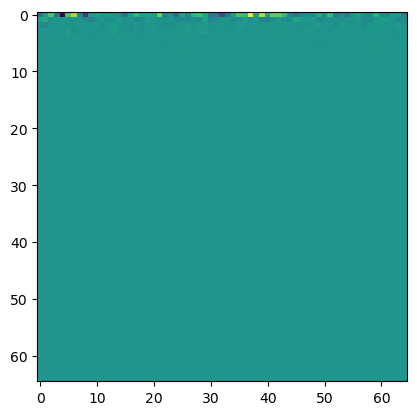

In [11]:
plt.imshow(latent_PCA[0].reshape((65, 65)))

### Evaluate PCA

In [13]:
# Select a specific l for demonstration
l = 100
X_train_reconstruced_PCA = reconstruct_data(latent_PCA, pca, l)
error = reconstruction_error(X_train_normalized, X_train_reconstruced_PCA)

print(f"Reconstruction Error for l={l}: {error}")

Reconstruction Error for l=100: 0.019434509798884392


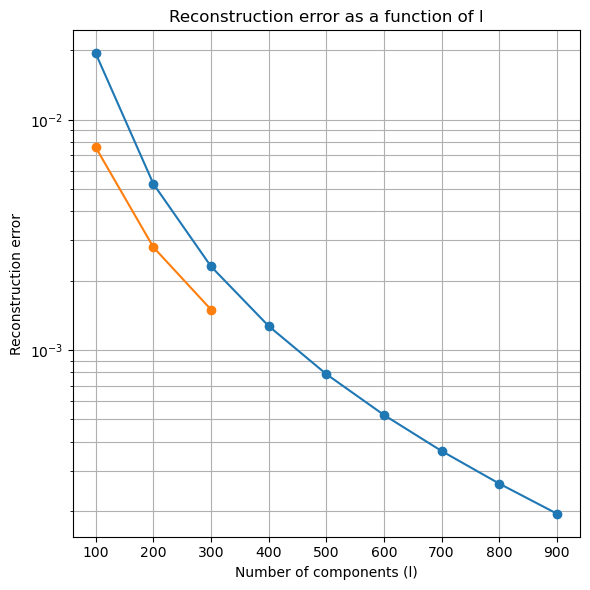

In [23]:
# Analyze reconstruction error for different number of components
#l_values = list(range(100,1000,100))
#errors = [reconstruction_error(X_train_normalized, reconstruct_data(latent_PCA, pca, l)) for l in l_values]

# Plotting the reconstruction errors
plt.figure(figsize=(6,6))
plt.semilogy(l_values[:], errors[:], marker='o')
plt.semilogy(l_values[:3],[0.0076, 0.0028, 0.0015], marker='o')
plt.grid(True, 'both')
plt.xlabel('Number of components (l)')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error as a function of l')
plt.tight_layout()
plt.show()

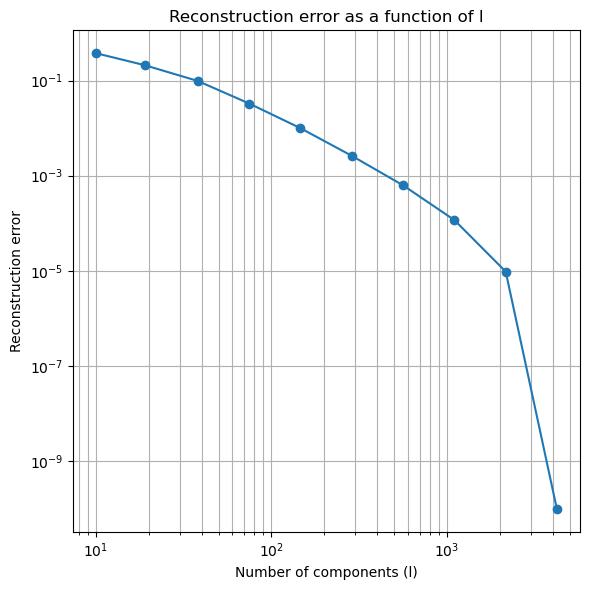

In [31]:
# Analyze reconstruction error for different number of components
l_values = [int(l) for l in np.logspace(1, np.log10(4225), 10)]
errors = [reconstruction_error(X_train_normalized, reconstruct_data(latent_PCA, pca, l)) for l in l_values]

# Plotting the reconstruction errors
plt.figure(figsize=(6,6))
plt.loglog(l_values, errors, marker='o')
plt.grid(True, 'both')
plt.xlabel('Number of components (l)')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error as a function of l')
plt.tight_layout()
plt.show()

211
0.00577092170715332


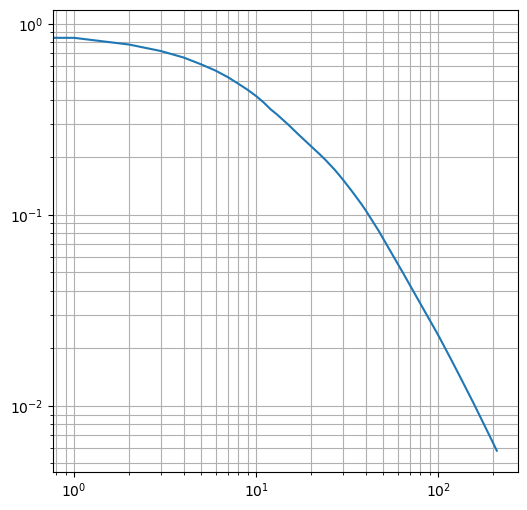

In [34]:
l=4225//20
0.007
print(l)
plt.figure(figsize=(6,6))
print(1-pca.explained_variance_ratio_.cumsum()[l])
plt.loglog(1 - pca.explained_variance_ratio_.cumsum()[:l])
plt.grid(which='both')

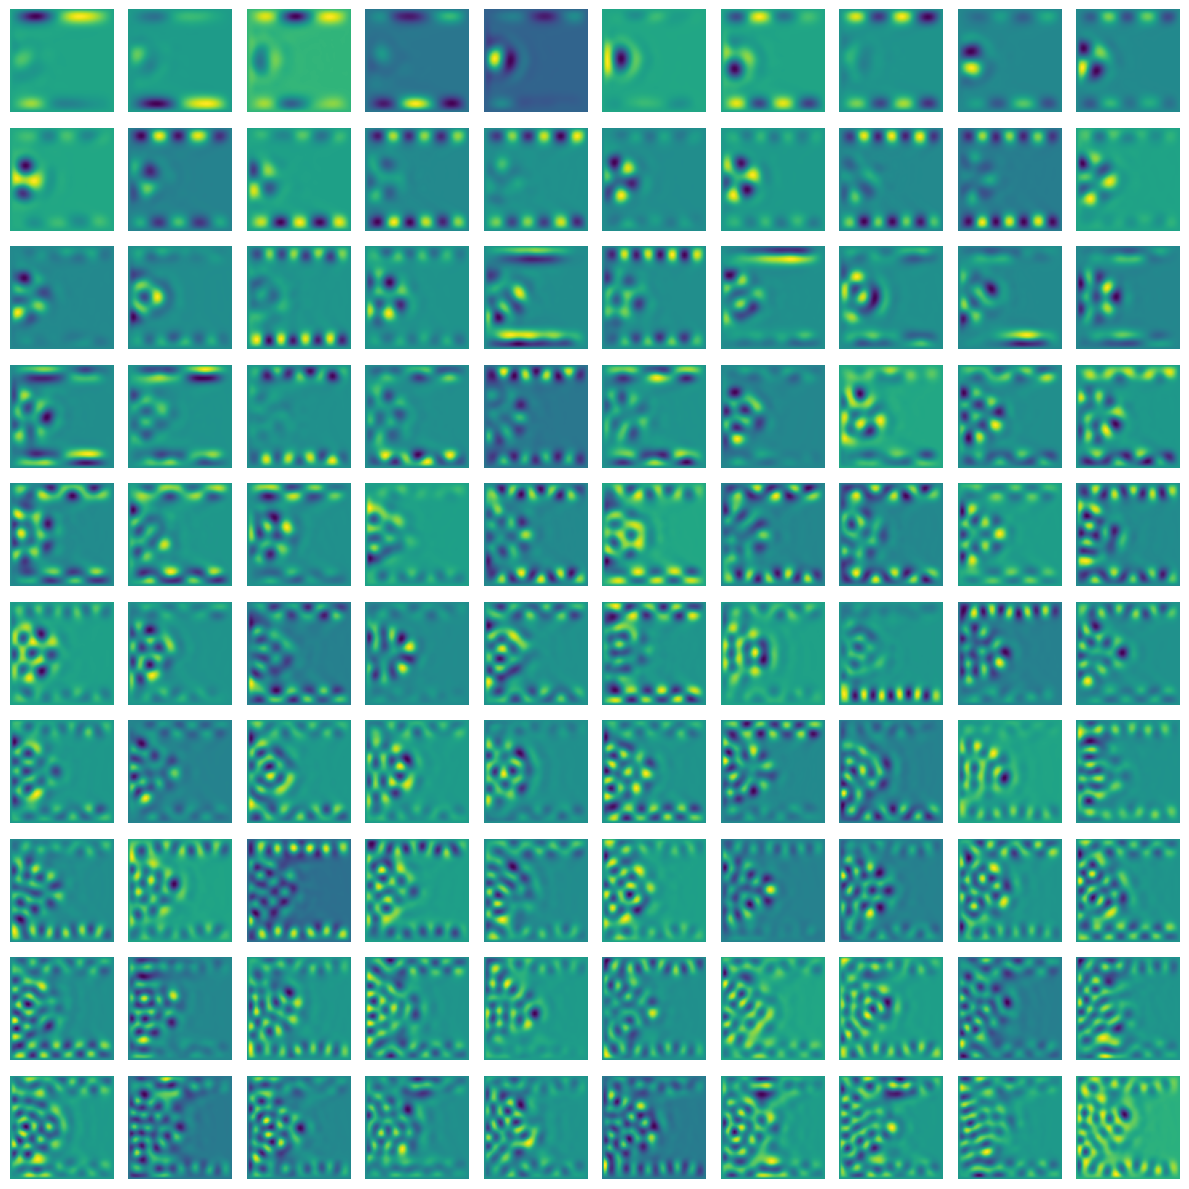

In [108]:
K = 100  # Number of components to 
bias_K = 0 # Bias to start from

fig, axs = plt.subplots(K//10, 10, figsize=(12, 12))
axs = axs.flatten()


for i in range(K):
    axs[i].imshow(pca.components_[i+bias_K, :].reshape(65, 65))
    axs[i].axis('off')

plt.tight_layout()
plt.show()


## Autoencoder

### Architectures (Run one here)

#### Old Architectures

In [136]:
# Linear Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size[0], hidden_size[1]),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size[1], hidden_size[0]),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size[0], input_size),
        )
        self.apply(self.init_weights)

    @staticmethod  
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [10]:
# First try of convolutional autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, filters):
        super(ConvAutoencoder, self).__init__()
        self.image_size = 65
        self.filters = filters
        
        self.encoder = nn.Sequential(
            nn.Unflatten(1,(1,self.image_size, self.image_size)),

            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            nn.ReLU(True),
            self._block(self.filters, self.filters, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._block(self.filters, self.filters*2, stride=1),
            self._block(self.filters*2, self.filters*2, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self._block(self.filters*2, self.filters*4, stride=1),
            self._block(self.filters*4, self.filters*4, stride=1),
            nn.Flatten(start_dim=1),

            nn.Linear(in_features=self.filters*4*16*16 ,out_features=100),
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=100,out_features=self.filters*4*16*16),
            nn.ReLU(True),
            nn.Unflatten(1,(self.filters*4, 16, 16)),
            self._block(self.filters*4, self.filters*4, stride=1),
            self._block(self.filters*4, self.filters*2, stride=1),
            nn.ConvTranspose2d(in_channels=self.filters*2, out_channels=self.filters*2, kernel_size=2, stride=2),
            self._block(self.filters*2, self.filters*2, stride=1),
            self._block(self.filters*2, self.filters, stride=1),
            nn.ConvTranspose2d(in_channels=self.filters, out_channels=self.filters, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=self.filters, out_channels=self.filters, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1),
            nn.Flatten(start_dim=1),
            )
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.InstanceNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [9]:
# Convolutional Autoencoder using maxpooling
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, filters, latent_dim=100, no_downsamples=2):
        super(ConvolutionalAutoencoder, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.latent_dim = latent_dim

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            nn.ReLU(True),
        ]

        for _ in range(self.no_downsamples):
            #encoder_layers.append(self._block(dim, dim, kernel_size=3, stride=1))
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
            encoder_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            dim *= 2

        enc_img_sz = self.image_size//2**self.no_downsamples
        
        encoder_layers.append(nn.Flatten(start_dim=1))
        encoder_layers.append(nn.Linear(in_features=dim * enc_img_sz * enc_img_sz, out_features=self.latent_dim))
        #encoder_layers.append(nn.Sigmoid())
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = [
            nn.Linear(in_features=self.latent_dim, out_features=dim * enc_img_sz * enc_img_sz),
            nn.Unflatten(1, (dim, enc_img_sz, enc_img_sz)),
        ]
        
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))
            decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
            #decoder_layers.append(self._block(dim//2, dim//2, kernel_size=3, stride=1))
            dim //= 2

        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [7]:
# Old version of the fully convolutional autoencoder
class FullyConvolutionalAutoencoder(nn.Module):
    def __init__(self, filters, latent_dim=100, no_downsamples=4):
        super(FullyConvolutionalAutoencoder, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.latent_dim = latent_dim

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            nn.ReLU(True),
        ]

        for _ in range(self.no_downsamples):
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=4, stride=2))
            dim *= 2
        
        encoder_layers.extend(self._block(dim, 6, kernel_size=3, stride=1))

        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = self._block(6, dim, kernel_size=3, stride=1)
        
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim//2, kernel_size=4, stride=2))
            dim //= 2

        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations

In [7]:
# PatchGAN
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.image_size = 65
        self.filters = 4
        
        self.model = nn.Sequential(
            nn.Unflatten(1,(1,self.image_size, self.image_size)),

            # Input shape: (batch_size, in_channels, 65, 65)
            self._block(1, self.filters, normalize=False),
            self._block(self.filters, self.filters*2),
            self._block(self.filters*2, self.filters*4),
            #self._block(self.filters*4, self.filters*8),

            nn.Conv2d(self.filters*4, 1, kernel_size=4, stride=1, padding=1)
        )

        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        return self.model(x)


#### Current Architectures (Run one here)

In [25]:
# Fully Convolutional Autoencoder
class FullyConvolutionalAutoencoder4(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, latent_dim=100, no_downsamples=2, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(FullyConvolutionalAutoencoder4, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.latent_dim = latent_dim
        self.activation = activation             #nn.LeakyReLU(0.2, inplace=True)

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            self.activation,
        ]

        for _ in range(self.no_downsamples):
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
            dim *= 2
            encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))

        enc_img_sz = self.image_size//2**self.no_downsamples
        
        #encoder_layers.append(nn.Flatten(start_dim=1))
        #encoder_layers.append(nn.Linear(in_features=dim * enc_img_sz * enc_img_sz, out_features=self.latent_dim))
        encoder_layers.append(nn.Conv2d(in_channels=dim, out_channels=6, kernel_size=3, padding=1))
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = [
            #nn.Linear(in_features=self.latent_dim, out_features=dim * enc_img_sz * enc_img_sz),
            #self.activation,
            #nn.Unflatten(1, (dim, enc_img_sz, enc_img_sz)),
        ]
        decoder_layers.extend(self._block(6, dim, kernel_size=3, stride=1))
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim//2, kernel_size=4, stride=2))
            dim //= 2
            decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations


In [8]:
# Small Convolutional Autoencoder
class ConvolutionalAutoencoder2(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, latent_dim=100, no_downsamples=2):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(ConvolutionalAutoencoder2, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.latent_dim = latent_dim
        # self.activation = nn.ReLU(True)

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            nn.ReLU(True),
        ]

        for _ in range(self.no_downsamples):
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=4, stride=2))
            dim *= 2

        enc_img_sz = self.image_size//2**self.no_downsamples
        
        encoder_layers.append(nn.Flatten(start_dim=1))
        encoder_layers.append(nn.Linear(in_features=dim * enc_img_sz * enc_img_sz, out_features=self.latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = [
            nn.Linear(in_features=self.latent_dim, out_features=dim * enc_img_sz * enc_img_sz),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (dim, enc_img_sz, enc_img_sz)),
        ]
        
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim//2, kernel_size=4, stride=2))
            dim //= 2

        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            #nn.LeakyReLU(0.2, inplace=True)
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations


In [70]:
# Large Convolutional Autoencoder (Preferred)
class ConvolutionalAutoencoder4(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, latent_dim=100, no_downsamples=2, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - latent_dim (int): Dimensionality of the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        """
        super(ConvolutionalAutoencoder4, self).__init__()
        self.image_size = 65
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.latent_dim = latent_dim
        self.activation = activation             #nn.LeakyReLU(0.2, inplace=True)

        dim = self.filters

        encoder_layers = [
            nn.Unflatten(1, (1,self.image_size, self.image_size)),
            nn.Conv2d(in_channels=1, out_channels=self.filters, kernel_size=4, padding=1),
            self.activation,
        ]

        for _ in range(self.no_downsamples):
            encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
            dim *= 2
            encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))

        enc_img_sz = self.image_size//2**self.no_downsamples
        
        encoder_layers.append(nn.Flatten(start_dim=1))
        encoder_layers.append(nn.Linear(in_features=dim * enc_img_sz * enc_img_sz, out_features=self.latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        decoder_layers = [
            nn.Linear(in_features=self.latent_dim, out_features=dim * enc_img_sz * enc_img_sz),
            self.activation,
            nn.Unflatten(1, (dim, enc_img_sz, enc_img_sz)),
        ]
        
        for _ in range(self.no_downsamples):
            decoder_layers.extend(self._upblock(dim, dim//2, kernel_size=4, stride=2))
            dim //= 2
            decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
        decoder_layers.append(nn.ConvTranspose2d(in_channels=self.filters, out_channels=1, kernel_size=4, padding=1))
        decoder_layers.append(nn.Flatten(start_dim=1))
        self.decoder = nn.Sequential(*decoder_layers)
        
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = self.encoder(x)
        activations = x  # Store the activations from the encoder
        x = self.decoder(x)
        return x, activations


In [ ]:
class UNet(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, image_size = 65, input_channels = 1, isUNet = False, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - no_latent_channels (int): Number of channels in the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        - activation (nn.Module): Activation function to use in the model.
        """
        super(UNet, self).__init__()
        self.image_size = image_size
        self.input_channels = input_channels
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation

        self.isUNet = isUNet
        scale = 2 if self.isUNet else 1
        kernel_size = 3 if self.isUNet else 4 # Change if not 65x65

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = []

        # Construct the encoder layers
        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=kernel_size, stride=1, batchnorm=False))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2

            if i == self.no_downsamples:
                if not self.isUNet:
                    encoder_layers.append(nn.Conv2d(dim, self.no_latent_channels, kernel_size=3, padding=1))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))

            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []

        # Construct the decoder layers
        for i in range(self.no_downsamples + 1):
            if i == 0:
                if not self.isUNet:
                    decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._block(dim*scale, dim, kernel_size=3, stride=1)) # Change for UNet
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=kernel_size, padding=1))
            else:
                decoder_layers.extend(self._block(dim, dim//2, kernel_size=3, stride=1))
                dim //= 2
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        """
        Helper function to create a convolutional block with optional batch normalization and activation.
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        """
        Helper function to create a transposed convolutional block with batch normalization and activation.
        """
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        """
        Initialize weights of the model.
        """
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)
    
    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        """
        Forward pass through the U-Net.
        """
        if self.isUNet:
            down_outputs = []

            for down in self.downs:
                x = down(x)
                down_outputs.append(x)

            activations = x

            for i, up in enumerate(self.ups):
                down_output = down_outputs.pop()
                if i > 0:
                    x = torch.cat([x, down_output], dim=1)
                x = up(x)
        else:
            x = self.encoder(x)
            activations = x
            x = self.decoder(x)
            
        return x, activations

In [71]:
class Autoencoder(nn.Module):
    """
    Convolutional Autoencoder for encoding and decoding images.
    """
    def __init__(self, filters, no_latent_channels=2, no_downsamples=3, image_size = 65, input_channels = 1, activation=nn.ReLU(True)):
        """
        Initializes the model with the specified configuration.
        
        Parameters:
        - filters (int): Number of filters in the first convolutional layer.
        - no_latent_channels (int): Number of channels in the latent space.
        - no_downsamples (int): Number of downsampling steps in the encoder.
        - activation (nn.Module): Activation function to use in the model.
        """
        super(Autoencoder, self).__init__()
        self.image_size = image_size
        self.input_channels = input_channels
        self.filters = filters
        self.no_downsamples = no_downsamples
        self.no_latent_channels = no_latent_channels
        self.activation = activation

        kernel_size = 4

        dim = self.filters

        # Encoder
        self.downs = nn.ModuleList()
        encoder_layers = []

        # Construct the encoder layers
        for i in range(self.no_downsamples+1):
            if i == 0:
                encoder_layers.extend(self._block(self.input_channels, dim, kernel_size=kernel_size, stride=1, batchnorm=False))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=4, stride=2))
                encoder_layers.extend(self._block(dim, dim*2, kernel_size=3, stride=1))
                dim *= 2

            if i == self.no_downsamples:
                encoder_layers.append(nn.Conv2d(dim, self.no_latent_channels, kernel_size=3, padding=1))
            else:
                encoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))

            self.downs.append(nn.Sequential(*encoder_layers))
            encoder_layers = []
        
        # Decoder
        self.ups = nn.ModuleList()
        decoder_layers = []

        # Construct the decoder layers
        for i in range(self.no_downsamples + 1):
            if i == 0:
                decoder_layers.extend(self._block(self.no_latent_channels, dim, kernel_size=3, stride=1))
            else:
                decoder_layers.extend(self._block(dim, dim, kernel_size=3, stride=1))
            
            if i == self.no_downsamples:
                decoder_layers.append(nn.ConvTranspose2d(in_channels=dim, out_channels=self.input_channels, kernel_size=kernel_size, padding=1))
            else:
                dim //= 2
                decoder_layers.extend(self._block(dim*2, dim, kernel_size=3, stride=1))
                decoder_layers.extend(self._upblock(dim, dim, kernel_size=4, stride=2))

            self.ups.append(nn.Sequential(*decoder_layers))
            decoder_layers = []
            
        # Initialize weights
        self.apply(self.init_weights)

    def _block(self, in_channels, out_channels, kernel_size, stride, batchnorm=True):
        """
        Helper function to create a convolutional block with optional batch normalization and activation.
        """
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(self.activation)
        return layers
        
    def _upblock(self, in_channels, out_channels, kernel_size, stride):
        """
        Helper function to create a transposed convolutional block with batch normalization and activation.
        """
        return [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            self.activation,
        ]
    
    @staticmethod
    def init_weights(m):
        """
        Initialize weights of the model.
        """
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ConvTranspose2d)):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 1.0, 0.02)
            torch.nn.init.constant_(m.bias, 0.0)
    
    def encoder(self, x):
        for down in self.downs:
            x = down(x)
        return x
    
    def decoder(self, x):
        for up in self.ups:
            x = up(x)
        return x
    
    def forward(self, x):
        """
        Forward pass through the U-Net.
        """
        
        x = self.encoder(x)
        activations = x
        x = self.decoder(x)
            
        return x, activations

### Check Number of Parameters

In [11]:
model = Autoencoder(filters=8, no_latent_channels=8, no_downsamples=4)  # Example sizes
model = Autoencoder(filters=16, no_latent_channels=4, no_downsamples=3)  # Example sizes
model = Autoencoder(filters=32, no_latent_channels=1, no_downsamples=2)  # Example sizes

model = Autoencoder(filters=16, no_latent_channels=2, no_downsamples=3)  # Example sizes

model.to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of parameters in the model: {total_params}")


for data, _ in train_loader:
    img = data
    output, activation = model(img)
    print(activation.shape)
    break

print(model.state_dict)

Total number of parameters in the model: 470211
torch.Size([64, 2, 8, 8])
<bound method Module.state_dict of Autoencoder(
  (activation): ReLU(inplace=True)
  (downs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [23]:
number_params = 0
for name, param in model.named_parameters(): 
    if param.requires_grad and 'weight' in name: 
        print(name, param.shape)
        number_params += param.numel()
print(number_params)

MLP.0.weight torch.Size([100, 100])
MLP.2.weight torch.Size([100, 100])
MLP.4.weight torch.Size([100, 100])
MLP.6.weight torch.Size([100, 100])
40000


In [72]:
# Load the saved model
date = '2024-02-21'
name = 'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1'
saved_model = torch.load(f'C://Users//svart//Desktop//MEX//results//{date}//{name}//best_model.pth')

# Create an instance of the ConvolutionalAutoencoder class
fully_conv_model = Autoencoder(filters=8, latent_dim=100, no_downsamples=4)

# Load the state_dict of the saved model into the conv_autoencoder
fully_conv_model.load_state_dict(saved_model)

fully_conv_model.to(device)

criterion = nn.MSELoss() #
optimizer = optim.Adam(fully_conv_model.parameters())#, weight_decay=0.00001)
#0.0001 gives 0.016 after 15 epochs.
#0.00001 gives 0.013 after 25 epochs. Similar train/val loss.

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

model = fully_conv_model

TypeError: __init__() got an unexpected keyword argument 'latent_dim'

In [73]:
date = '2024-02-21'
name = 'ae-3ds-16f-4l-150e-L1-0wd-0.00001l1'#'ae-2ds-32f-1l-150e-L1-0wd-0.00001l1'

autoencoder_path = Path(f'C://Users//svart//Desktop//MEX//results//{date}//{name}')

import json
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Diffusion.ipynb
# Load the saved model
saved_model = torch.load(autoencoder_path / 'best_model.pth')

# Read parameters from JSON file
with open(autoencoder_path / 'config.json', 'r') as json_file:
    parameters = json.load(json_file)

# Extract the desired parameters
filters = parameters['filters']
latent_dim = parameters['latent_dim']
no_downsamples = parameters['no_downsamples']

# Create an instance of the ConvolutionalAutoencoder class
autoencoder = Autoencoder(filters= filters, no_latent_channels=latent_dim, no_downsamples=no_downsamples)

# Load the state_dict of the saved model into the conv_autoencoder
autoencoder.load_state_dict(saved_model)

autoencoder.to(device)
model = autoencoder

### Training

#### Current Training (Run two here)

In [33]:
# Define model
#fully_conv_model = ConvolutionalAutoencoder4(filters=16, latent_dim=100, no_downsamples=4)  # Example sizes
fully_conv_model = Autoencoder(filters=8, no_latent_channels=8, no_downsamples=4)  # Example sizes

fully_conv_model.to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(fully_conv_model.parameters())#, weight_decay=0.00001)

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])

model = fully_conv_model

In [34]:
# Training loop
num_epochs = 1

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    
    for data, _ in train_loader:
        img = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Reconstruction loss
        recon_loss = criterion(output, img)
        loss = recon_loss 

        total_train_loss += loss.item()


        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data,_ in val_loader:
            img = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # scheduler.step()

    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

KeyboardInterrupt: 

Empty DataFrame
Columns: [Epoch, Average Training Loss, Validation Loss]
Index: []


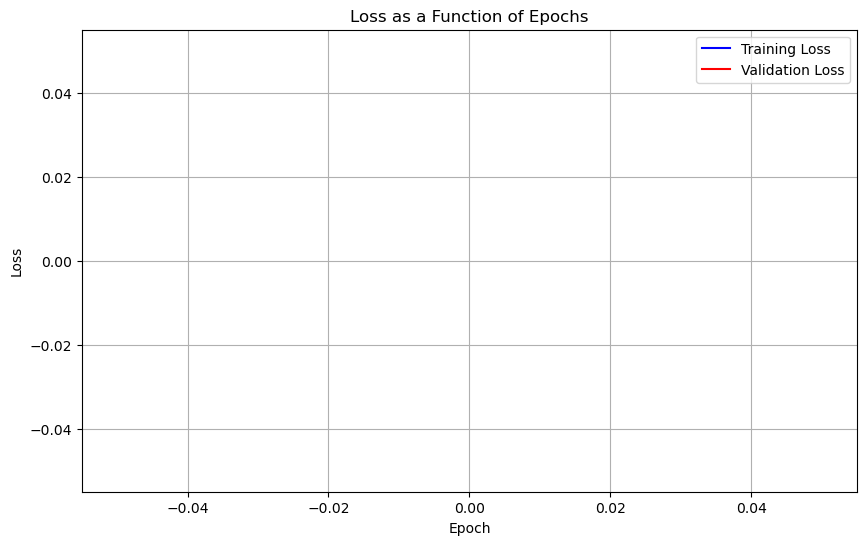

In [13]:
# Plot from logfile
log_file_path = 'training_log.csv'
df = pd.read_csv(log_file_path)

# Display the first few rows of the dataframe
print(df)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'][1:], df['Average Training Loss'][1:], label='Training Loss', color='blue')
plt.plot(df['Epoch'][1:], df['Validation Loss'][1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Old training

##### Adversarial loss

In [135]:
# Initialize models
generator = FullyConvolutionalAutoencoder(filters=16).to(device)#ConvAutoencoder(filters=32).to(device)
discriminator = Discriminator().to(device)

# Loss functions
criterion_reconstruction = nn.MSELoss()  # Loss for reconstruction (Generator)
criterion_GAN = nn.MSELoss()            # Loss for GAN (Discriminator)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-3)

# Determining the size of image patches for the Discriminator
patch_height, patch_width = 65 // 2**3, 65 // 2**3
patch = (1, patch_height, patch_width)

loss_values = []

In [136]:
num_epochs = 100
lambda_g = 0.01

# Training loop
for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    # Initialize cumulative losses for epoch
    cumulative_loss = {
        "generator": 0, "discriminator": 0, "reconstruction": 0,
        "fooling": 0
    }
    
    for img, _ in train_loader:
        valid_labels = torch.ones((img.size(0), *patch), device=device)
        fake_labels = torch.zeros((img.size(0), *patch), device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate reconstructed images
        reconstructed_images, latent = generator(img)

        # Fooling loss (Generator's success in fooling the Discriminator)
        predictions_from_fake = discriminator(reconstructed_images.detach())
        fooling_loss = criterion_GAN(predictions_from_fake, valid_labels)

        # Reconstruction loss (How similar the reconstructed and real images are)
        reconstruction_loss = criterion_reconstruction(reconstructed_images, img)

        # Total Generator loss
        generator_loss = reconstruction_loss + lambda_g * fooling_loss
        generator_loss.backward()
        optimizer_G.step()

        # Update cumulative losses
        cumulative_loss["generator"] += generator_loss.item()
        cumulative_loss["reconstruction"] += reconstruction_loss.item()
        cumulative_loss["fooling"] += fooling_loss.item()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images (Discriminator's ability to identify real images)
        predictions_from_real = discriminator(img)
        real_loss = criterion_GAN(predictions_from_real, valid_labels)

        # Loss for fake images (Discriminator's ability to identify fake images)
        predictions_from_fake = discriminator(reconstructed_images.detach())
        fake_loss = criterion_GAN(predictions_from_fake, fake_labels)   

        # Total Discriminator loss
        discriminator_loss = 0.5 * (real_loss + fake_loss)
        discriminator_loss.backward()
        optimizer_D.step()

        # Update cumulative losses
        cumulative_loss["discriminator"] += discriminator_loss.item()

    # Calculate average losses for the epoch
    avg_losses = {key: value / len(train_loader) for key, value in cumulative_loss.items()}
    loss_values.append(avg_losses)

    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}] - ' +
          f'Gen.: {avg_losses["generator"]:.4f}, ' +
          f'Recon.: {avg_losses["reconstruction"]:.4f}, ' +
          f'Fool.: {avg_losses["fooling"]:.4f}, ' +
          f'Disc.: {avg_losses["discriminator"]:.4f}, '
    )

# Plotting Losses
plt.figure(figsize=(10, 6))
for key in avg_losses:
    plt.semilogy([loss[key] for loss in loss_values][16:], label=f'{key} Loss')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/100] - Gen.: 0.3368, Recon.: 0.3321, Fool.: 0.4628, Disc.: 0.1545, 


KeyboardInterrupt: 

##### L2 reg

In [32]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

Epoch [1/50], Average Loss: 0.3232, Reconstruction: 0.3113, L2: 0.0119, Validation Loss: 0.0887
Epoch [2/50], Average Loss: 0.0684, Reconstruction: 0.0565, L2: 0.0120, Validation Loss: 0.0543
Epoch [3/50], Average Loss: 0.0493, Reconstruction: 0.0374, L2: 0.0119, Validation Loss: 0.0399
Epoch [4/50], Average Loss: 0.0412, Reconstruction: 0.0294, L2: 0.0118, Validation Loss: 0.0347
Epoch [5/50], Average Loss: 0.0365, Reconstruction: 0.0248, L2: 0.0117, Validation Loss: 0.0292
Epoch [6/50], Average Loss: 0.0334, Reconstruction: 0.0219, L2: 0.0115, Validation Loss: 0.0285
Epoch [7/50], Average Loss: 0.0314, Reconstruction: 0.0201, L2: 0.0114, Validation Loss: 0.0243
Epoch [8/50], Average Loss: 0.0301, Reconstruction: 0.0188, L2: 0.0113, Validation Loss: 0.0244
Epoch [9/50], Average Loss: 0.0290, Reconstruction: 0.0177, L2: 0.0113, Validation Loss: 0.0220
Epoch [10/50], Average Loss: 0.0282, Reconstruction: 0.0170, L2: 0.0112, Validation Loss: 0.0226
Epoch [11/50], Average Loss: 0.0273, Re

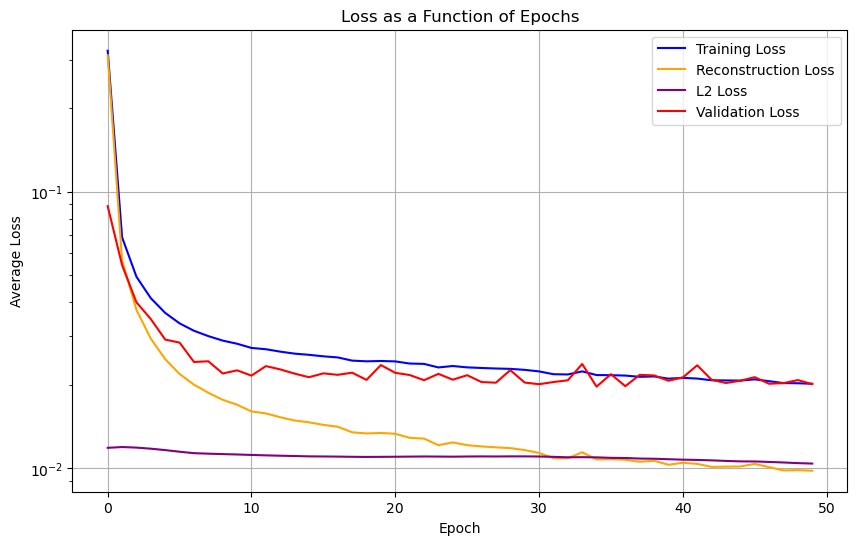

In [33]:
num_epochs = 50

# lambda_l1 = 0.001
lambda_l2 = 0.0001
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    # total_l1_loss = 0
    total_l2_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        # l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.norm(param, 2)

        l2_loss *= lambda_l2

        loss = recon_loss + l2_loss # + l1_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        # total_l1_loss += l1_loss.item()
        total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    # avg_l1_loss = total_l1_loss / len(train_loader)
    avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l2_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L2: {avg_l2_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='L2 Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

##### L1

In [154]:
fully_conv_model = ConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss() #
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []
best_val_loss = float('inf')

model = fully_conv_model

In [155]:
num_epochs = 50

lambda_l1 = 0.0001
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    total_l1_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        loss = recon_loss + l1_loss 

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        total_l1_loss += l1_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_l1_loss = total_l1_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l1_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L1: {avg_l1_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[:,0], label='Training Loss', color='blue')
plt.plot(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.plot(loss_plot[:,2], label='L1 Loss', color='purple')

plt.plot(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

Epoch [1/50], Average Loss: 0.3018, Reconstruction: 0.2766, L1: 0.0251, Validation Loss: 0.1002
Epoch [2/50], Average Loss: 0.0635, Reconstruction: 0.0546, L1: 0.0089, Validation Loss: 0.0611


KeyboardInterrupt: 

##### L1 and L2

In [41]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

Epoch [1/50], Average Loss: 0.3341, Reconstruction: 0.2935, L1: 0.0288, L2: 0.0118, Validation Loss: 0.0943
Epoch [2/50], Average Loss: 0.0853, Reconstruction: 0.0628, L1: 0.0105, L2: 0.0119, Validation Loss: 0.0616
Epoch [3/50], Average Loss: 0.0585, Reconstruction: 0.0419, L1: 0.0046, L2: 0.0120, Validation Loss: 0.0491
Epoch [4/50], Average Loss: 0.0479, Reconstruction: 0.0331, L1: 0.0029, L2: 0.0119, Validation Loss: 0.0380
Epoch [5/50], Average Loss: 0.0419, Reconstruction: 0.0277, L1: 0.0023, L2: 0.0119, Validation Loss: 0.0334
Epoch [6/50], Average Loss: 0.0388, Reconstruction: 0.0250, L1: 0.0020, L2: 0.0119, Validation Loss: 0.0326
Epoch [7/50], Average Loss: 0.0361, Reconstruction: 0.0224, L1: 0.0019, L2: 0.0118, Validation Loss: 0.0276
Epoch [8/50], Average Loss: 0.0350, Reconstruction: 0.0214, L1: 0.0017, L2: 0.0118, Validation Loss: 0.0259
Epoch [9/50], Average Loss: 0.0331, Reconstruction: 0.0197, L1: 0.0016, L2: 0.0118, Validation Loss: 0.0265
Epoch [10/50], Average Loss:

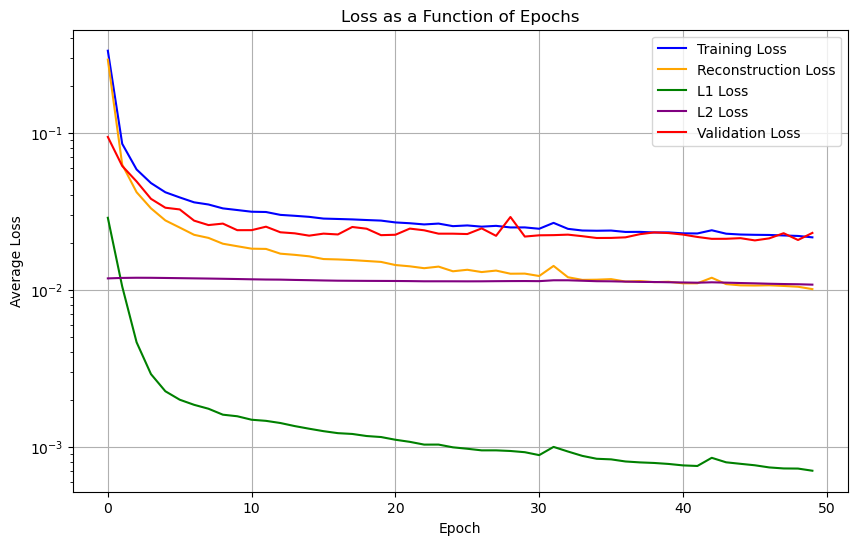

In [42]:
num_epochs = 50

lambda_l1 = 0.0001
lambda_l2 = 0.0001
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    total_l1_loss = 0
    total_l2_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.norm(param, 2)

        l2_loss *= lambda_l2

        loss = recon_loss + l1_loss + l2_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        total_l1_loss += l1_loss.item()
        total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    avg_l1_loss = total_l1_loss / len(train_loader)
    avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_l1_loss, avg_l2_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, L1: {avg_l1_loss:.4f}, L2: {avg_l2_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='L1 Loss', color='green')
plt.semilogy(loss_plot[:,3], label='L2 Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

##### KL

In [9]:
fully_conv_model = FullyConvolutionalAutoencoder(filters=16)  # Example sizes
fully_conv_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(fully_conv_model.parameters(), lr=1e-3)#, weight_decay=0.0001)

loss_values = []
val_loss_values = []

model = fully_conv_model

In [ ]:
def kl_divergence(rho, rho_hat):
    """
    Calculate the Kullback-Leibler divergence between two Bernoulli distributions.

    Parameters:
    rho (torch.Tensor): Mean of the first Bernoulli distribution.
    rho_hat (torch.Tensor): Mean of the second Bernoulli distribution.

    Returns:
    torch.Tensor: KL divergence between the two Bernoulli distributions.
    """
    term_one = rho * torch.log(rho / rho_hat)
    term_two = (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    return torch.sum(term_one + term_two)

def kl_divergence(self, activations):
    rho = 0.05  # Sparsity parameter, you can adjust this
    rho_hat = torch.mean(activations, 0)  # Average over batch
    kl_div = rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))
    return torch.sum(kl_div)

In [25]:
def get_modules(model):
    modules = []
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            modules.append(module)
    return modules

model_children = get_modules(model)
model_children

[Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Linear(in_features=16384, out_features=100, bias=True),
 Linear(in_features=100, out_features=16384, bias=True),
 Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

In [27]:
def kl_divergence(rho, rho_hat):
    rho_hat = torch.mean(F.sigmoid(rho_hat), 1) # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(rho_hat)).to(device)
    return torch.sum(rho * torch.log(rho/rho_hat) + (1 - rho) * torch.log((1 - rho)/(1 - rho_hat)))
# define the sparse loss function

def sparse_loss(rho, images):
    values = images
    loss = 0
    for i in range(len(model_children)):
        values = model_children[i](values)
        loss += kl_divergence(rho, values)
    return loss

In [28]:
num_epochs = 50

#lambda_l1 = 0.0001
# lambda_l2 = 0.0001
lambda_kl = 0.01
rho = 0.05

best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    total_recon_loss = 0
    #total_l1_loss = 0
    #total_l2_loss = 0
    total_kl_loss = 0
    
    for data in train_loader:
        img, _ = data

        optimizer.zero_grad()

        output, activations = model(img)

        # Recondstruction loss
        recon_loss = criterion(output, img)

        # L1 regularization
        #l1_loss = lambda_l1 * torch.mean(torch.norm(activations, 1, dim=1))

        # Calculate L2 loss (sum of absolute values of weights)
        #l2_loss = 0
        #for param in model.parameters():
        #    l2_loss += torch.norm(param, 2)

        #l2_loss *= lambda_l2

        kl_loss = lambda_kl * sparse_loss(rho, img)

        loss = recon_loss + kl_loss # + l1_loss # + l2_loss

        total_train_loss += loss.item()

        total_recon_loss += recon_loss.item()
        total_kl_loss += kl_loss.item() 
        #total_l1_loss += l1_loss.item()
        #total_l2_loss += l2_loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_recon_loss = total_recon_loss / len(train_loader)
    #avg_l1_loss = total_l1_loss / len(train_loader)
    # avg_l2_loss = total_l2_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            img, _ = data

            output, _ = model(img)
            loss = criterion(output, img)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    avg_kl_loss = total_kl_loss / len(val_loader)

    # Checkpointing
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduling (if applicable)
    # scheduler.step()

    loss_values.append([avg_train_loss, avg_recon_loss, avg_kl_loss])
    val_loss_values.append(avg_val_loss)  # Assuming val_loss_values list exists

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Reconstruction: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.semilogy(loss_plot[:,0], label='Training Loss', color='blue')
plt.semilogy(loss_plot[:,1], label='Reconstruction Loss', color='orange')
plt.semilogy(loss_plot[:,2], label='KL Loss', color='purple')

plt.semilogy(val_loss_values, label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 4225]

## Visualization (Run here to see images)

In [74]:
# Choose settings
cmap = 'viridis'
choose_val = False
doPCA = False # Not sure if True works right now :D
selected_loader = val_loader if choose_val else train_loader

In [75]:
def get_images(selected_loader, l=100):
    model.eval()

    for data in selected_loader:
        img, img_next = data
        break

    img = img[0].to(device)
    img_next = img_next[0].to(device)

    image_shape = (65, 65)  # Replace with the actual shape of your images
    latent_shape = (4,8,8)

    img_ae = model(img.unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)
    img_ae_next = model(img_next.unsqueeze(0))[0].cpu().detach().numpy().reshape(image_shape)

    img_ae_enc = model.encoder(img.unsqueeze(0)).cpu().detach().numpy().reshape(latent_shape)
    img_ae_enc_next = model.encoder(img_next.unsqueeze(0)).cpu().detach().numpy().reshape(latent_shape)

    img = img.cpu().detach().numpy()
    img_next = img_next.cpu().detach().numpy()

    if doPCA: 
        img_pca = reconstruct_data(pca.transform(img.reshape(1, -1)), pca, l).reshape(image_shape)
        img_pca_next = reconstruct_data(pca.transform(img_next.reshape(1, -1)), pca, l).reshape(image_shape)

        img_pca_enc = get_encoded(img, l)
        img_pca_enc_next = get_encoded(img_next,l)
    else:
        img_pca = np.zeros(image_shape)
        img_pca_next = np.zeros(image_shape)
        img_pca_enc = np.zeros((4225))
        img_pca_enc_next = np.zeros((4225))
    
    
    img_train = img.reshape(image_shape)
    img_train_next = img_next.reshape(image_shape)
    

    
    return img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next

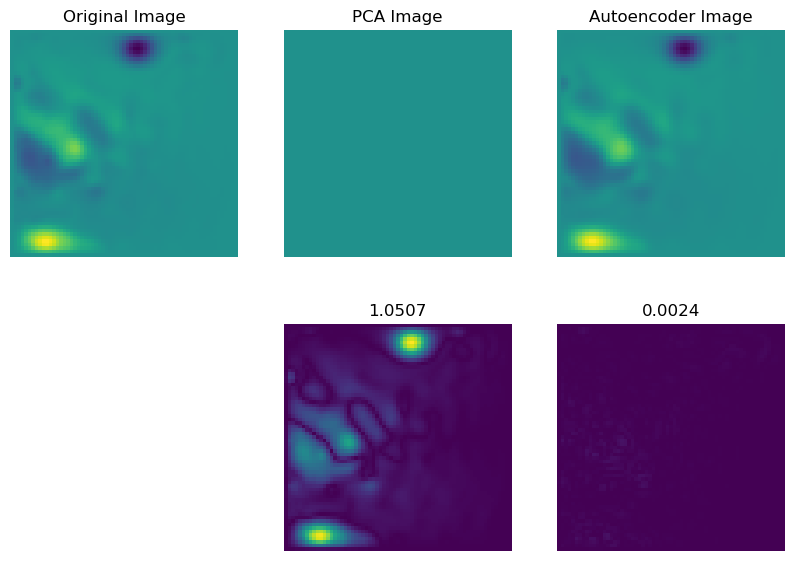

In [76]:
# Reconstruction
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
get_images(selected_loader)

vmin = min(img_pca.min(), img_train.min(), img_ae.min())
vmax = max(img_pca.max(), img_train.max(), img_ae.max())

#cmap = 'Greys'

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes[0,0].imshow(img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

axes[0,1].imshow(img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,1].set_title(f'PCA Image')
axes[0,1].axis('off')

axes[0,2].imshow(img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,2].set_title(f'Autoencoder Image')
axes[0,2].axis('off')

#axes[1,0].plot(img_pca_enc.flatten())
#axes[1,0].set_title('Encoded Image')
axes[1,0].axis('off')

#vmin_diff = min((img_pca-img_train).min(), (img_ae-img_train).min())
vmax_diff = max((np.abs(img_pca-img_train)).max(), (np.abs(img_ae-img_train)).max())

axes[1,1].imshow(np.abs(img_pca- img_train), cmap=cmap, vmin=0, vmax=vmax_diff)
er_PCA = np.round(reconstruction_error(img_train, img_pca),4)
axes[1,1].set_title(f'{str(er_PCA)}')
axes[1,1].axis('off')

axes[1,2].imshow(np.abs(img_ae-img_train), cmap=cmap, vmin=0, vmax=vmax_diff)
er_AE = np.round(reconstruction_error(img_train, img_ae), 4)
axes[1,2].set_title(f'{str(er_AE)}')
axes[1,2].axis('off')

plt.show()

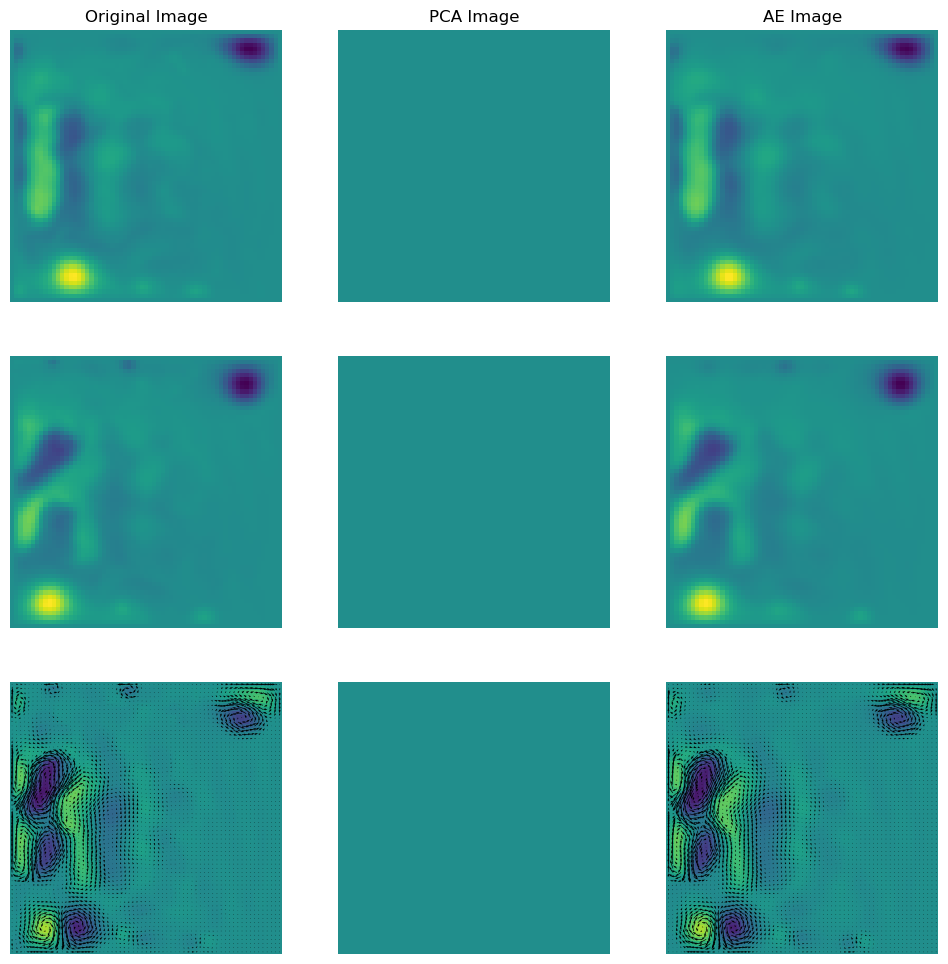

In [80]:
# Gradient
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
get_images(selected_loader)


vmin = min(img_pca.min(), img_train.min(), img_train_next.min(), img_pca_next.min())
vmax = max(img_pca.max(), img_train.max(), img_train_next.max(), img_pca_next.max())

fig, axes = plt.subplots(3,3, figsize=(12, 12))

# Train
axes[0,0].imshow(img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

axes[1,0].imshow(img_train_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,0].axis('off')

gradient_x, gradient_y = np.gradient(img_train_next - img_train)
X, Y = np.meshgrid(np.arange(gradient_x.shape[1]), np.arange(gradient_y.shape[0]))
axes[2,0].imshow(img_train_next - img_train, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,0].quiver(X, Y, gradient_x, gradient_y)
axes[2,0].axis('off')


# PCA
axes[0,1].imshow(img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,1].set_title(f'PCA Image')
axes[0,1].axis('off')

axes[1,1].imshow(img_pca_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,1].axis('off')

# Compute the difference
difference = img_pca_next - img_pca
gradient_x, gradient_y = np.gradient(difference)
axes[2,1].imshow(img_pca_next - img_pca, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,1].quiver(X, Y, gradient_x, gradient_y)
axes[2,1].axis('off')

# AE
axes[0,2].imshow(img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0,2].set_title(f'AE Image')
axes[0,2].axis('off')

axes[1,2].imshow(img_ae_next, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1,2].axis('off')

# Compute the difference
difference = img_ae_next - img_ae
gradient_x, gradient_y = np.gradient(difference)
axes[2,2].imshow(img_ae_next - img_ae, cmap=cmap, vmin=vmin, vmax=vmax)
axes[2,2].quiver(X, Y, gradient_x, gradient_y)
axes[2,2].axis('off')


plt.show()

## Evaluation of PCA and Autoencoder Models

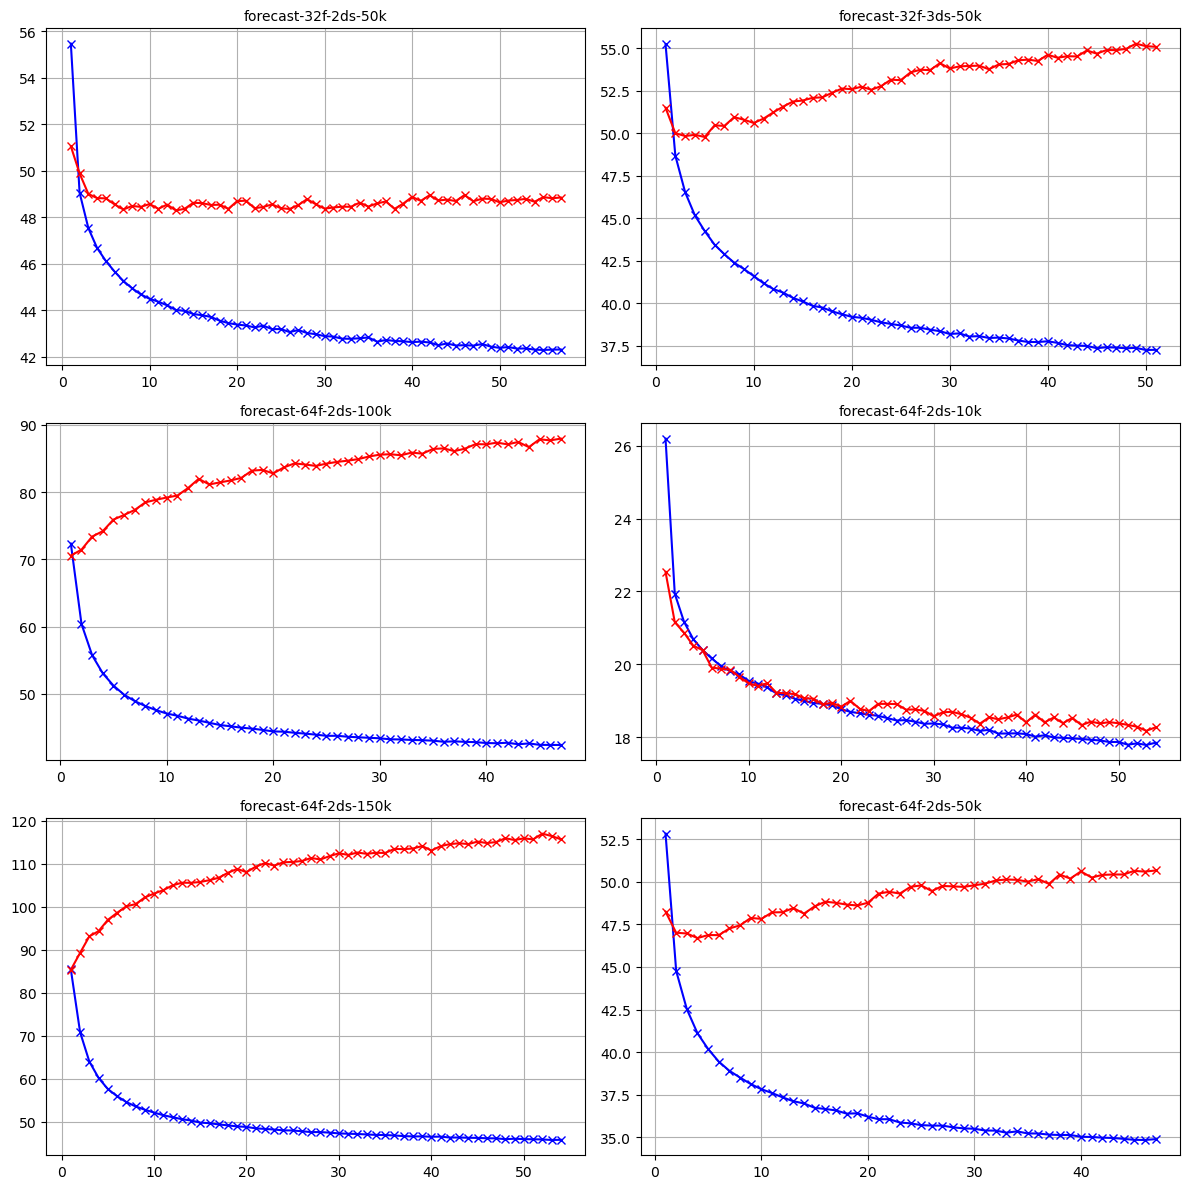

In [8]:
import os
# FILEPATH: /c:/Users/svart/Desktop/MEX/QG-Forecasting/Training.ipynb
date = '2024-02-22'
log_file_path = f"C:\\Users\\svart\\Desktop\\MEX\\results\\{date}"
# Get all subdirectories in log_file_path
subdirs = [os.path.join(log_file_path, subdir) for subdir in os.listdir(log_file_path) if os.path.isdir(os.path.join(log_file_path, subdir))]
#log_file_path = "C:\\Users\\svart\\Desktop\\MEX\\results\\240208"
#subdirs.extend([os.path.join(log_file_path, subdir) for subdir in os.listdir(log_file_path) if os.path.isdir(os.path.join(log_file_path, subdir))])

exclude_list = ["00l", "L1", "fully-3ds-16f", "240208","2ds", "32f"]
include_list = ["forecast"]

# Filter subdirs to exclude directories containing any of the strings in exclude_list
#subdirs = [subdir for subdir in subdirs if not any(exclude_str in subdir for exclude_str in exclude_list)]
subdirs = [subdir for subdir in subdirs if all(include_str in subdir for include_str in include_list)]

# Create a subplot grid
num_subplots = len(subdirs)
num_rows = 3
num_cols = (num_subplots + 1) // num_rows  # Adjust the number of columns based on the number of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))#, sharey=True)

# Iterate over each subdirectory
for i, subdir in enumerate(subdirs):
    # Get the path to the training log file
    log_file = os.path.join(subdir, "training_log.csv")
    
    # Read the training log file into a DataFrame
    df = pd.read_csv(log_file)
    
    # Get the subdirectory name
    subdir_name = os.path.basename(subdir)
    
    #if "00l" in subdir_name or "L1" in subdir_name:
    #    continue
    # Calculate the row and column indices for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Plot the training and validation loss in the corresponding subplot
    start = 0
    axs[row_idx, col_idx].plot(df['Epoch'][start:], df['Average Training Loss'][start:], label='Training Loss', color='blue', marker = 'x')
    axs[row_idx, col_idx].plot(df['Epoch'][start:], df['Validation Loss'][start:], label='Validation Loss', color='red', marker='x')
    axs[row_idx, col_idx].set_title(f'{subdir_name}', fontsize=10)
    #axs[row_idx, col_idx].set_xlabel('Epoch')
    #axs[row_idx, col_idx].set_ylabel('Loss')
    #axs[row_idx, col_idx].legend()
    axs[row_idx, col_idx].grid(True)
    
    # Set the same limits on the axis for all subplots
    #axs[row_idx, col_idx].set_xlim([0, max(df['Epoch'])])
    #axs[row_idx, col_idx].set_ylim([0.006, 0.01])#max(df['Average Training Loss'][start:].max(), df['Validation Loss'][start:].max())])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
# Evaluating the performance of the PCA and Autoencoder models on the validation set.

# Function for model evaluation
def evaluate_model(model, selected_loader, criterion, pca, l):
    """
    Evaluate the model performance.

    Parameters:
    model (nn.Module): PyTorch model to evaluate.
    X_data (numpy.array): Data to evaluate the model on.
    criterion (function): Loss function.
    pca (PCA): PCA object.
    l (int): Number of PCA components.

    Returns:
    tuple: Tuple containing reconstruction errors for PCA and Autoencoder.
    """

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_ae_loss = 0
    total_pca_loss = 0
    with torch.no_grad():
        for data, _ in selected_loader:
            img = data

            X_AE_reconstructed, _ = model(img)
            total_ae_loss += criterion(X_AE_reconstructed, img).item()

            X_PCA_reconstructed = reconstruct_data(pca.transform(img.cpu().numpy()), pca, l)
            total_pca_loss += criterion(torch.tensor(X_PCA_reconstructed).to(device), img).item()

    avg_pca_loss = total_pca_loss / len(selected_loader)
    avg_ae_loss = total_ae_loss / len(selected_loader)

    return avg_pca_loss, avg_ae_loss

# Evaluate the models
error_pca, error_ae = evaluate_model(model, val_loader, nn.MSELoss(), pca, l=99)
print(f"PCA Reconstruction Error: {error_pca}, Autoencoder Reconstruction Error: {error_ae}")

PCA Reconstruction Error: 0.009046140885003275, Autoencoder Reconstruction Error: 0.009046140885003275


## Latent space visuals

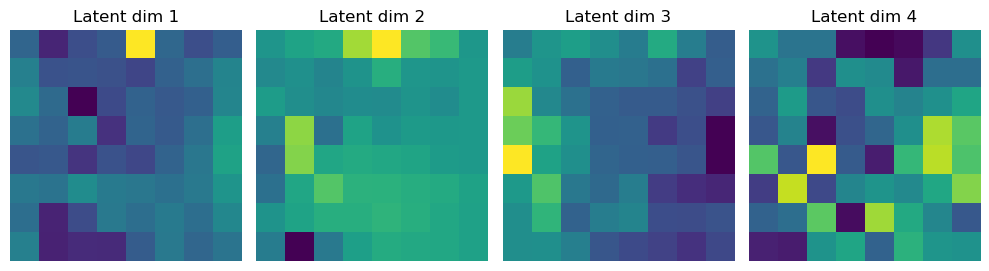

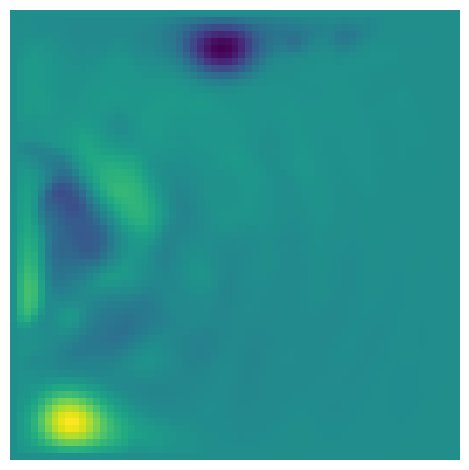

In [66]:
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
    get_images(train_loader)
    #get_images(random_index=random_index, X=X_chosen)

latent_dim = 4
fig, axes = plt.subplots(1, latent_dim, figsize=(10,4))

for i in range(latent_dim):
    axes[i].imshow(img_ae_enc[i,:,:], cmap='viridis')
    axes[i].set_title(f'Latent dim {i+1}')
    axes[i].axis('off')

plt.tight_layout()

plt.figure()
plt.imshow(img_train, cmap='viridis')
plt.axis('off')
plt.tight_layout()

plt.show()


TypeError: Invalid shape (4, 8, 8) for image data

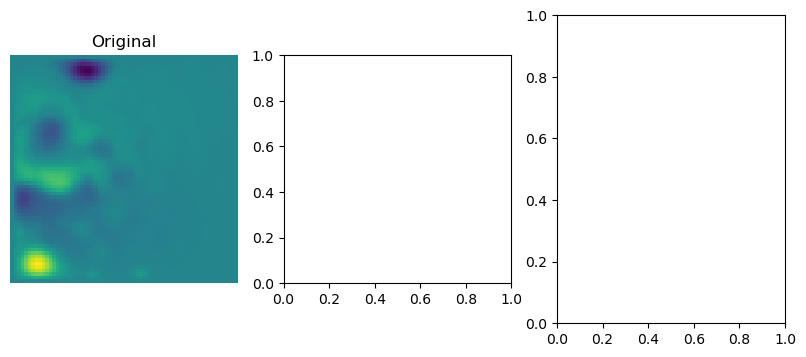

In [58]:
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
    get_images(train_loader)
    #get_images(random_index=random_index, X=X_chosen)

fig, axes = plt.subplots(1, 3, figsize=(10,4))

axes[0].imshow(img_train, cmap='viridis')
axes[0].set_title(f'Original')
axes[0].axis('off')

axes[1].imshow(img_ae_enc, cmap='viridis')
axes[1].set_title(f'Encoded')
axes[1].axis('off')

axes[2].imshow(img_ae, cmap='viridis')
axes[2].set_title(f'Autoencoder')
axes[2].axis('off')


plt.tight_layout()
plt.show()


In [ ]:
if choose_random:
    random_index = np.random.randint(len(X_val))
img_train, img_train_next, img_pca, img_pca_next, img_ae, img_ae_next, img_pca_enc, img_pca_enc_next, img_ae_enc, img_ae_enc_next = \
    get_images(train_loader)
    #get_images(random_index=random_index, X=X_chosen)


vmin_pca = min(img_pca_enc.min(), img_pca_enc_next.min())
vmax_pca = max(img_pca_enc.max(), img_pca_enc_next.max())

err_pca = str(np.round(np.mean(((img_pca_enc_next - img_pca_enc)/(vmax_pca - vmin_pca))**2),4))

vmin_ae = min(img_ae_enc.min(), img_ae_enc_next.min())
vmax_ae = max(img_ae_enc.max(), img_ae_enc_next.max())

err_ae = str(np.round(np.mean(((img_ae_enc_next - img_ae_enc)/(vmax_ae - vmin_ae))**2),4))

fig, axes = plt.subplots(3,2, figsize=(12, 12))

axes[0,0].plot(img_pca_enc)
axes[0,0].set_title(f'PCA\n{err_pca}')
axes[0,0].set_ylim([vmin_pca, vmax_pca])

axes[1,0].plot(img_pca_enc_next)
axes[1,0].set_ylim([vmin_pca, vmax_pca])

axes[2,0].plot(img_pca_enc_next - img_pca_enc)
axes[2,0].set_ylim([vmin_pca, vmax_pca])


axes[0,1].plot(img_ae_enc)
axes[0,1].set_title(f'AE\n{err_ae}')
axes[0,1].set_ylim([vmin_ae, vmax_ae])
axes[1,1].plot(img_ae_enc_next)
axes[1,1].set_ylim([vmin_ae, vmax_ae])
axes[2,1].plot(img_ae_enc_next - img_ae_enc)
axes[2,1].set_ylim([vmin_ae, vmax_ae])


plt.show()


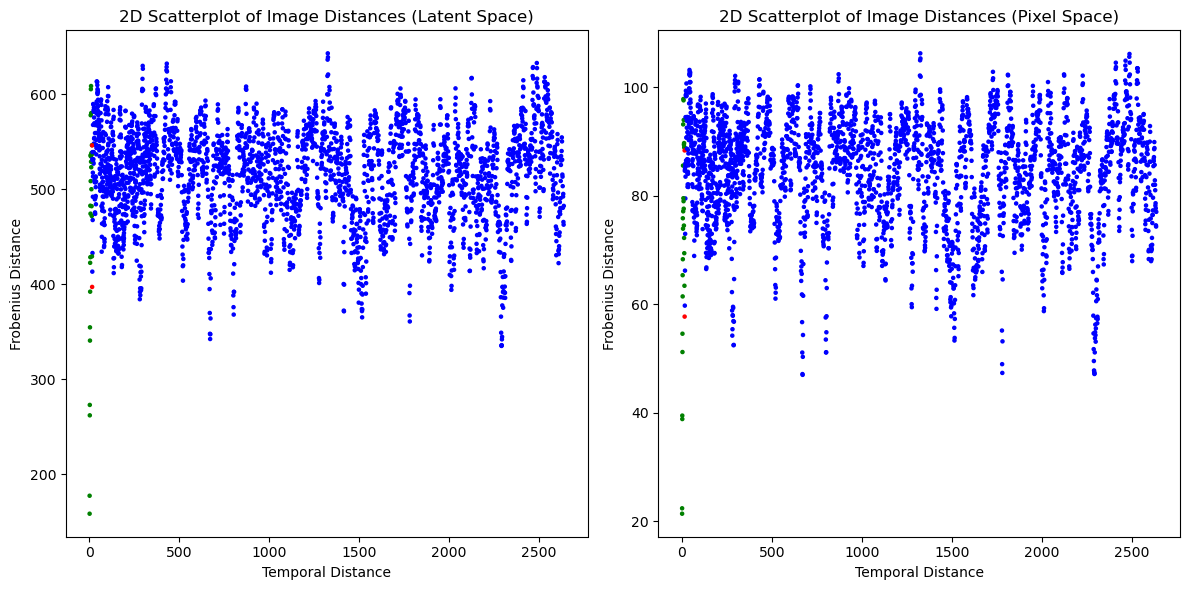

In [36]:
# Fix a random image index
for data, _ in train_loader:
    random_image = data[0]
    break

# Get the latent representation of the random image
random_image_latent = model.encoder(random_image.unsqueeze(0)).cpu().detach().numpy()
random_image = random_image.cpu().detach().numpy()

# Calculate the distances between the random image's latent representation and all other latent representations
latent_distances = []
temporal_distances = []
frobenius_distances = []

for data i
for i, image in enumerate(X_val_normalized):
    if i != random_image_index:
        image_latent = model.encoder(X_val_tensor[i].unsqueeze(0)).cpu().detach().numpy().flatten()

        frobenius_distance = np.linalg.norm(random_image - image)
        latent_distance = np.linalg.norm(random_image_latent - image_latent)
        temporal_distance = abs(random_image_index - i)

        latent_distances.append(latent_distance)
        temporal_distances.append(temporal_distance)
        frobenius_distances.append(frobenius_distance)

# Plot the scatterplot
K_color = 15  # Threshold for coloring points
colors = ['green' if d < K_color else 'red' if d == K_color else 'blue' for d in temporal_distances]

plt.figure(figsize=(12, 6))  # Adjust the figure size as desired

# Plot the first scatterplot
plt.subplot(1, 2, 1)
plt.scatter(temporal_distances, latent_distances, c=colors, s=5)  # Adjust the scatter dot size with 's' parameter
plt.xlabel('Temporal Distance')
plt.ylabel('Frobenius Distance')
plt.title('2D Scatterplot of Image Distances (Latent Space)')

# Plot the second scatterplot
plt.subplot(1, 2, 2)
plt.scatter(temporal_distances, frobenius_distances, c=colors, s=5)  # Adjust the scatter dot size with 's' parameter
plt.xlabel('Temporal Distance')
plt.ylabel('Frobenius Distance')
plt.title('2D Scatterplot of Image Distances (Pixel Space)')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


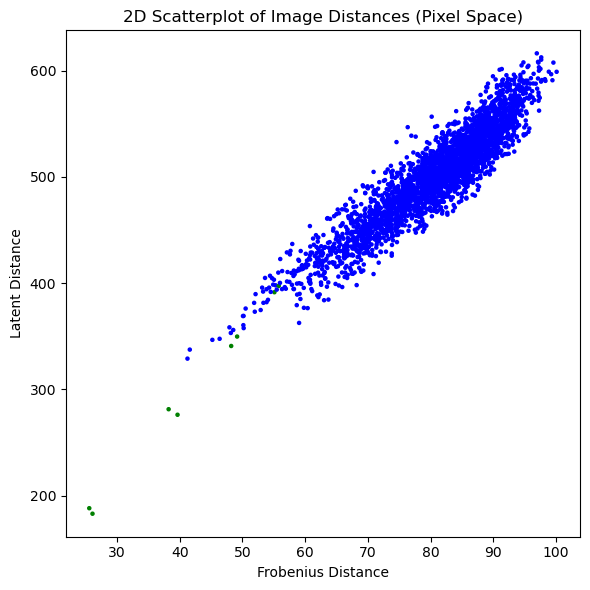

In [37]:
# Fix a random image index
random_image_index = np.random.randint(len(X_val_normalized))

# Get the latent representation of the random image
random_image_latent = model.encoder(X_val_tensor[random_image_index].unsqueeze(0)).cpu().detach().numpy().flatten()
random_image = X_val_normalized[random_image_index]


# Calculate the distances between the random image's latent representation and all other latent representations
latent_distances = []
temporal_distances = []
frobenius_distances = []

for i, image in enumerate(X_val_normalized):
    if i != random_image_index:
        image_latent = model.encoder(X_val_tensor[i].unsqueeze(0)).cpu().detach().numpy().flatten()

        frobenius_distance = np.linalg.norm(random_image - image)
        latent_distance = np.linalg.norm(random_image_latent - image_latent)
        temporal_distance = abs(random_image_index - i)

        latent_distances.append(latent_distance)
        temporal_distances.append(temporal_distance)
        frobenius_distances.append(frobenius_distance)

# Plot the scatterplot
K_color = 5  # Threshold for coloring points
colors = ['green' if d < K_color else 'blue' for d in temporal_distances]

plt.figure(figsize=(6, 6))  # Adjust the figure size as desired

plt.scatter(frobenius_distances, latent_distances, c=colors, s=5)  # Adjust the scatter dot size with 's' parameter
plt.ylabel('Latent Distance')
plt.xlabel('Frobenius Distance')
plt.title('2D Scatterplot of Image Distances')

plt.title('2D Scatterplot of Image Distances (Pixel Space)')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


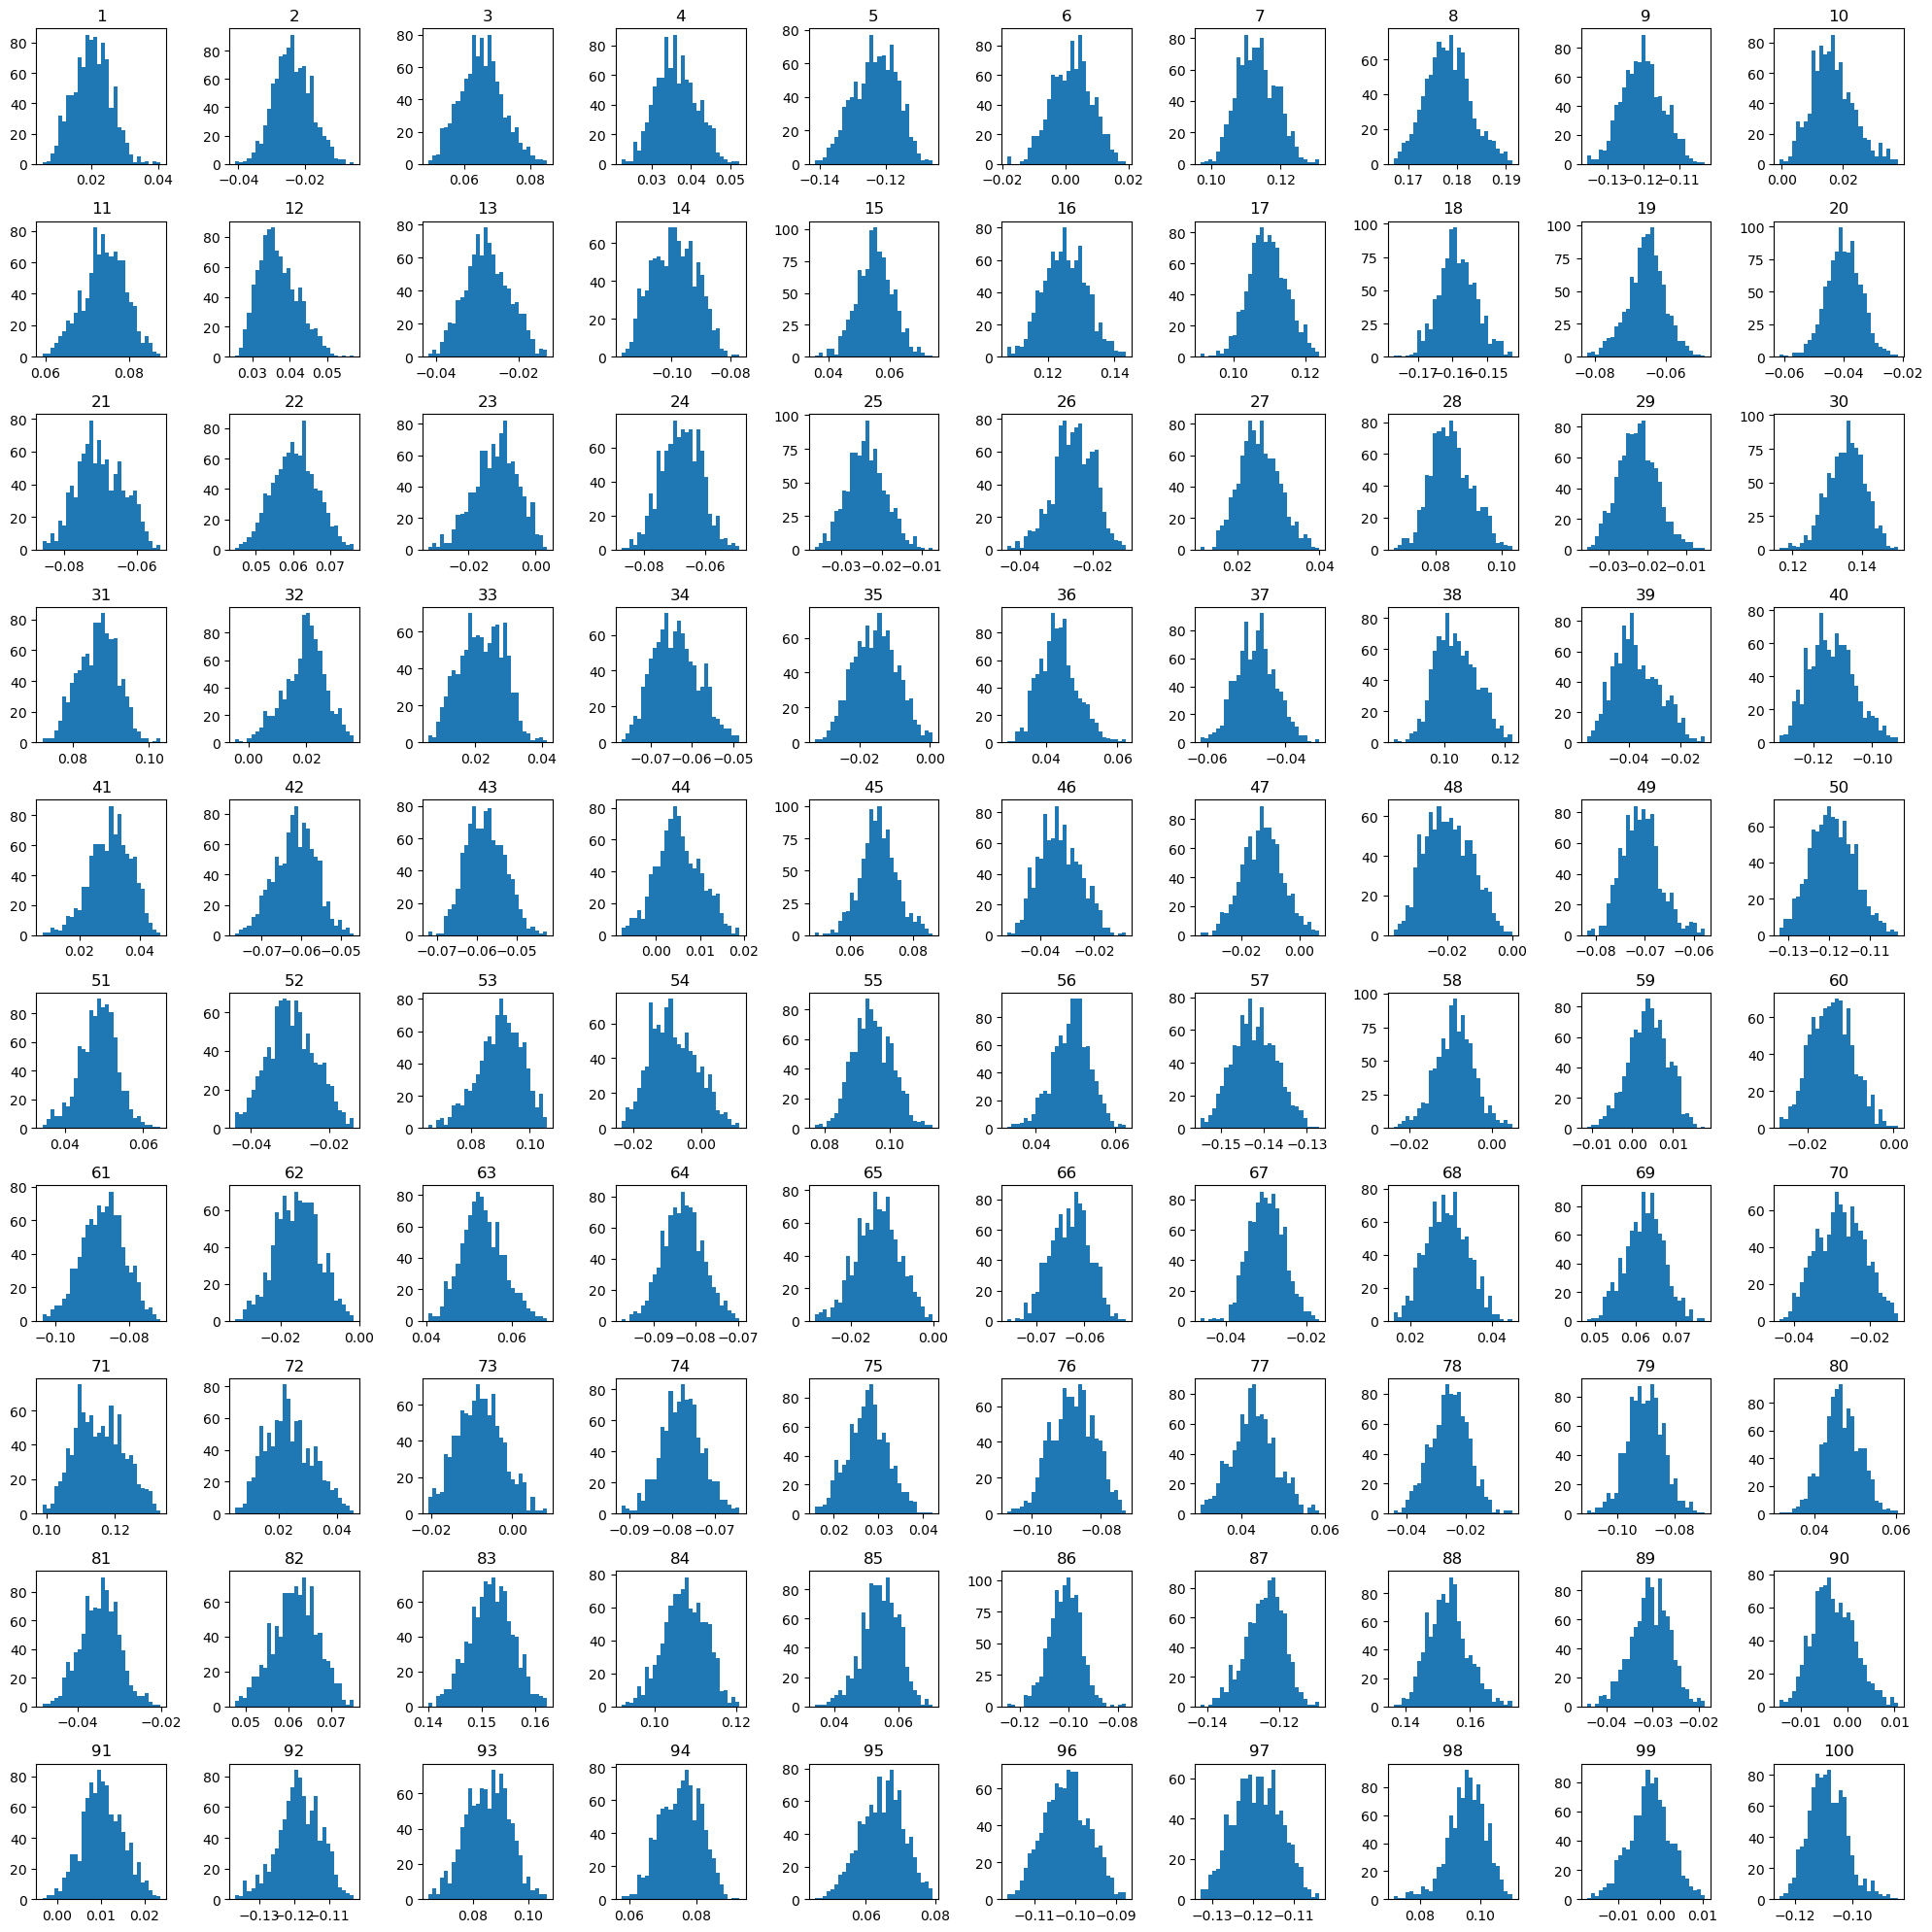

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Get the latent representations of all images in the validation set
latent_representations = []
for i, image in enumerate(X_val_normalized):
    latent_representations.append(model.encoder(X_val_tensor[i].unsqueeze(0)).cpu().detach().numpy().flatten())

# Calculate the histogram for each direction in the latent space
histograms = []
bins_list = []
for i in range(latent_representations[0].shape[0]):
    values = [latent[i] for latent in latent_representations]
    histogram, bins = np.histogram(values, bins=30)
    histograms.append(histogram)
    bins_list.append(bins)

# Create the subplot
fig, axs = plt.subplots(10, 10, figsize=(20, 20))

# Plot the histograms in the subplot
for i in range(10):
    for j in range(10):
        bins = bins_list[i*10+j]
        axs[i, j].bar(bins[:-1], histograms[i*10+j], width=(bins[1]-bins[0]))
        axs[i, j].set_title(f'{i*10+j+1}')
        #axs[i, j].set_xlabel('Latent Value')
        #axs[i, j].set_ylabel('Frequency')
        #axs[i, j].set_xlim([-0.15, 0.15])

plt.tight_layout()
plt.show()


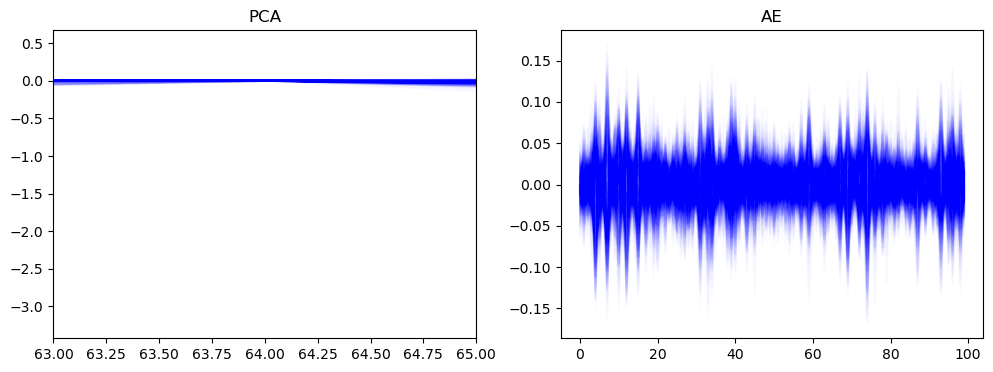

In [101]:
model.eval()

l = 100

cmap = 'viridis'
random_index = np.random.randint(len(X_val))

fig, axes = plt.subplots(1,2, figsize=(12, 4))

axes[0].set_title(f'PCA')
axes[1].set_title(f'AE')

for i in range(len(X_val)):
    random_index = i
    img_pca_enc = get_encoded(X_PCA_test[random_index], l)
    #img_pca_enc_next = get_encoded(X_PCA_test[random_index+1],l)

    img_ae_enc = model.encoder(X_val_tensor[random_index].unsqueeze(0)).cpu().detach().numpy().flatten()
    #img_ae_enc_next = model.encoder(X_val_tensor[random_index+1].unsqueeze(0)).cpu().detach().numpy().flatten()

    axes[0].plot(img_pca_enc, alpha=0.01, color='blue')

    axes[1].plot(img_ae_enc, alpha=0.01, color='blue')

axes[0].set_xlim([63,65])
plt.show()
random_index = 0
